# Exercise 1: PIONIER observation of Canopus

In this example we will demonstrate how to use oimodeler to create a simple model and perform model-fitting. We will also introduce the concepts of $\chi^2$ minimization and of local and global minima.

We will use VLTI/PIONIER data obtained on the giant star Canopus ($\alpha$ Carinae) as an example.

The Canopus dataset consist on 3 oifits files found in the data directory:
- PIONI.2014-01-12T00\_56\_41\.191\_oidataCalibrated.fits
- PIONI.2014-02-02T02\_15\_51.790\_oidataCalibrated.fits
- PIONI.2014-02-05T06\_22\_09.362\_oidataCalibrated.fits

You can download them and place them in a dedicated folder


## Part 1: Fitting a simple Uniform Disk model

In the part we will run a basic **oimodeler** script fitting a uniform disk model on our Canopus data

#### First we import the oimodeler module

In [1]:
import oimodeler as oim

#### Then we set the path to our oifits files. 

In [2]:
from pathlib import Path
dir0 = Path("C:\\Travail\\Cours et TP\\VLTI2024\\OIDATA\\data\\oifits\\canopus") # SET THIS TO THE PATH WITH THE CANOPUS DATA
files = list(dir0.glob("PION*.fits"))

files

[WindowsPath('C:/Travail/Cours et TP/VLTI2024/OIDATA/data/oifits/canopus/PIONI.2014-01-12T00_56_41.191_oidataCalibrated.fits'),
 WindowsPath('C:/Travail/Cours et TP/VLTI2024/OIDATA/data/oifits/canopus/PIONI.2014-02-02T02_15_51.790_oidataCalibrated.fits'),
 WindowsPath('C:/Travail/Cours et TP/VLTI2024/OIDATA/data/oifits/canopus/PIONI.2014-02-05T06_22_09.362_oidataCalibrated.fits')]

#### We then create a model containing a single uniform disk component.

In [3]:
ud = oim.oimUD()
model_ud = oim.oimModel(ud)

model_ud #printing the content of the model 

oimModel at 0x1360553add0:
oimUD at 0x1360522a150 : x=0.00 y=0.00 f=1.00 d=0.00

The uniform disk component has 4 parameters : 

- the position x and y, 
- the flux f, 
- and the diameter d. 

The x and y parameters are fixed by default but not the flux. 

#### Here we define the parameter space for the diameter and set the flux as a fixed parameter

After setting-up the parameter space, we can use the **getFreeParameter** method of the model to list the free parameters and their range

In [4]:
ud.params['d'].set(min=0,max=25)
ud.params['f'].free=False

model_ud.getFreeParameters() #printing the free parameters (and the range) of the model 

{'c1_UD_d': oimParam at 0x13604077450 : d=0 ± 0 mas range=[0,25] free=True }

#### We then create a MCMC fitter containing our PIONIER data and our uniform disk model. 
We will use 10 walkers to explorer the parameters space (minimum should be 2 walker by dimension of the space).  
oimodeler MCMC fitter is using the famous [emcee](https://emcee.readthedocs.io/en/stable/) python package.  

The **dataTypes** option allows to select which observable we want to use for our fit.

In [5]:
fit = oim.oimFitterEmcee(files, model_ud,nwalkers=10,
                         dataTypes=["VIS2DATA","T3PHI"])

#### **Question: What would be the minimum number of walkers for our problem?**

#### **Question: Which interferometric quantities are we using for our mcmc run?**

#### We then initialise our walkers to random positions within the parameters space and run it for 2000 steps.

In [6]:
fit.prepare(init="random")
fit.run(nsteps=2000, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.68it/s]


{'nsteps': 2000, 'progress': True}

Finally, after a few seconds, we can get the result from our MCMC run.

#### Let's first plot the position of the walkers as a function of the steps. 

This so called WalkerPlot will help evaluate after how many step (or if) the walkers have converged to the same position.


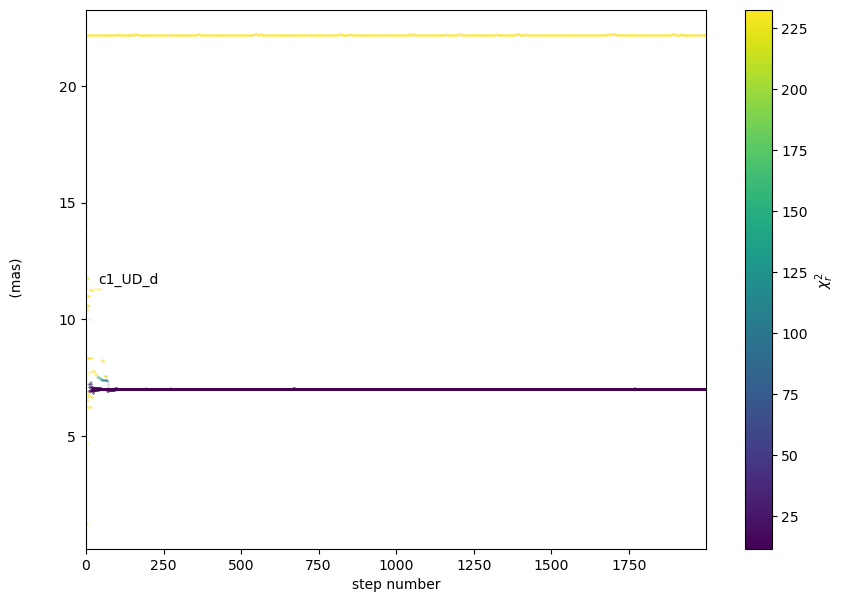

In [7]:
figwalkers, axwalkers = fit.walkersPlot()

#### **Question: Have all the walkers converged to the same position?**

#### **Question: Is one position significantly better than the others?**

#### **Question: Give a rough estimate of the number of steps needed to reach the positions**

In the next subsection we will see that the positions are the global and some locals minima. 

But before, let's produce a few other plots

#### The corner plot, often used with mcmc run, allow to visualise the multidimensional samples using a scatter- plot matrix. 

As after convergence the walkers of a mcmc run are supposed to represent the posterior probability function such plot help to estimate the parameters best values, uncertainties and correlations. 

To ensure that our sample has converged we will remove:
- the first 1000 steps
- $\chi^2_r$ above 5 times the minimum (to remove walkers stuck in local minima)

Of course, for our one-dimensional problem, the corner plot only show the histogram of our unique free parameter: the diameter **d**.


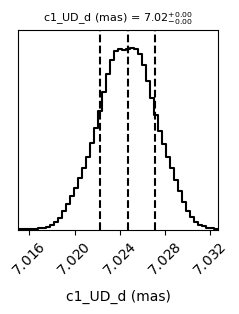

In [8]:
figcorner, axcorner = fit.cornerPlot(discard=1000, chi2limfact=5)

#### We can plot the data and simulated data for comparison

Note that in this example, we set the squared-visibility scale to logarithmic to show the second lobe of visibility.

(1e-05, 1)

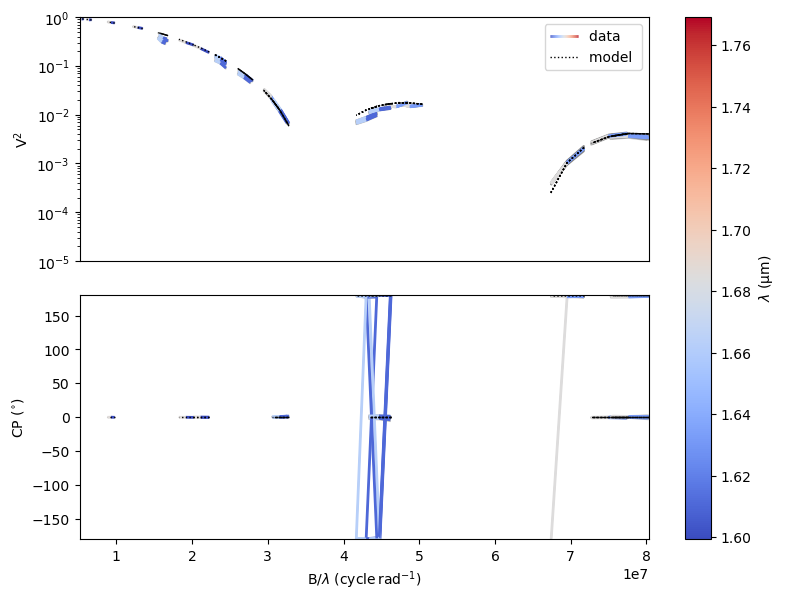

In [9]:
fig, ax = fit.simulator.plot(["VIS2DATA","T3PHI"])
ax[0].set_yscale("log")
ax[0].set_ylim(1e-5, 1)

Finally we can:
- print the values of our best fit model using the **printResult** method
- get these values using the **getResult** method
- get an image of the best model using the **showModel** method


c1_UD_d = 7.02461 ± 0.00248 mas
chi2r = 11.65689


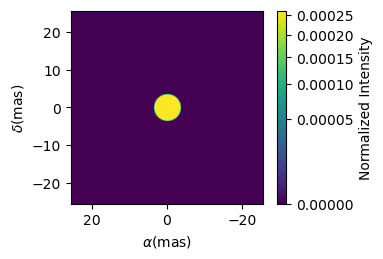

In [10]:
fit.printResults(discard=1000, chi2limfact=5)
median,err_l,err_u,err = fit.getResults(discard=1000, chi2limfact=5)
figim, axim, im = model_ud.showModel(512,0.1)

#### **Question: What is best-fit uniform disk diameter?**

#### **Question: Is it compatible with the value from the JSDC?**

#### **Question: Is the fit satisfying?**

## About local and global minima

Before using a more complex model, let's try to understand why all walkers do not converge to the same position. 

#### To do this, we will construct a grid of $\chi^2_r$ as a function of the diameter. 

We will explore values from 0 to 25 mas with a step of 0.1 mas.

We will take into account only the **VISDATA** in our $\chi^2$ computation for simplicity

100%|████████████████████████████████████████████████████████████████████████████| 2501/2501 [00:01<00:00, 1966.08it/s]


1


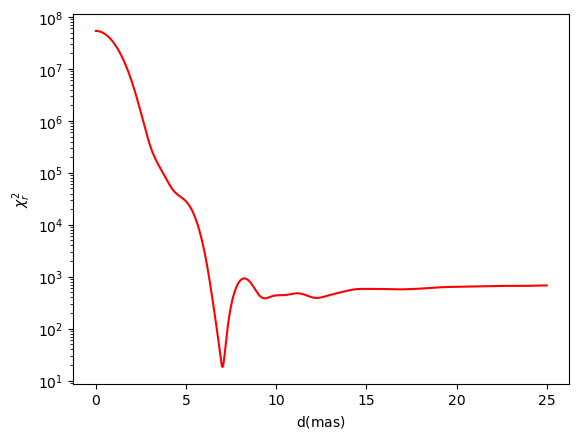

In [13]:
grid = oim.oimFitterRegularGrid(files, model_ud, dataTypes=["VIS2DATA"])
grid.prepare(steps=[0.01],min=[0],max=[25])
grid.run()
fig,ax = grid.plotMap()
ax.set_yscale("log") # comment to zoom 
#ax.set_ylim(1,1e3) # uncomment to zoom 

#### **Question: Does the global minimum correspond to some walkers converged positions? What about locals minima?**

#### **Question: Why isn't the $\chi^2$ variation smooth? Can you modify the code to make it smooth?**

Unlike simple $\chi^2$ minimisation which would converge to the closest minimum, mcmc is able to explore a wider parameters space and is more likely to conminimization which would converge to the closest minimum (but nothing can mathematically prove that it will). 

#### A simple $\chi^2$ minimisation is implemented in oimodeler 
It uses the [scipy.optimize.minimize method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

Here is how to use it :

In [15]:
ud.params["d"].value=4
miniz = oim.oimFitterMinimize(files, model_ud,dataTypes=["VIS2DATA"])
miniz.prepare()
miniz.run()
miniz.printResults()

c1_UD_d = 7.02461 ± 0.00167 mas
chi2r = 18.39331


#### **Question: Why isn't it converging to the global minimum?**

#### **Question: Modify the code above so that it converges to the global minimum**

The uncertainties on the parameters  are derived by mcmc and the minimize function using drastically different method:
- **MCMC** uses a statistical approach 
- **minimize** uses the inverse hessian matrix

> **Note:** The scipy.minimize function has problem estimating uncertainties when the starting position is too close to the final results.



## Part Two: Beyond the uniform Disk

#### **Question: Is the $\chi^2_r$ on our dataset satisfying? Can you find the reason Why?**

We will now use a power law limb darkening disk model (PLDD). In that model the limb darkening is defined by 

$$\frac{I(\mu)}{I(1)} = \mu^a $$

$\mu$ is the cosine of the angle $\theta$ between the direction perpendicular to the stellar surface and the direction toward a distant observer. 

For a line-of-sight starting at the centre and moving toward the limb of the stellar disk, $\mu$ varies between 1 and 0.

The PLDD model is very similar to the UD model but for an additional parameter, the limb-darkening exponent \textbf{a}. 

Here we set this parameter range from 0 to 1.

#### We Create a simple model containing a Power Law Limb Darkened Disk

In [16]:
pldd=oim.oimPowerLawLDD()
model_pldd=oim.oimModel(pldd)
pldd.params["a"].set(min=0,max=1)
pldd.params["d"].set(min=0,max=30)
pldd.params["f"].free=False

### Let's run a MCMC fitter and plot the results

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 42.46it/s]


c1_PLLDD_d = 7.24379 ± 0.00601 mas
c1_PLLDD_a = 0.19942 ± 0.00517 
chi2r = 6.06760


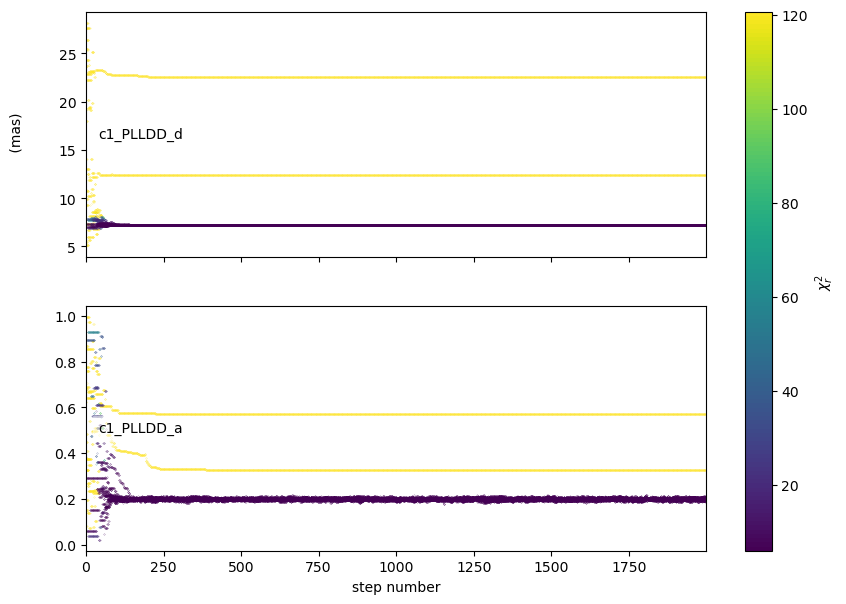

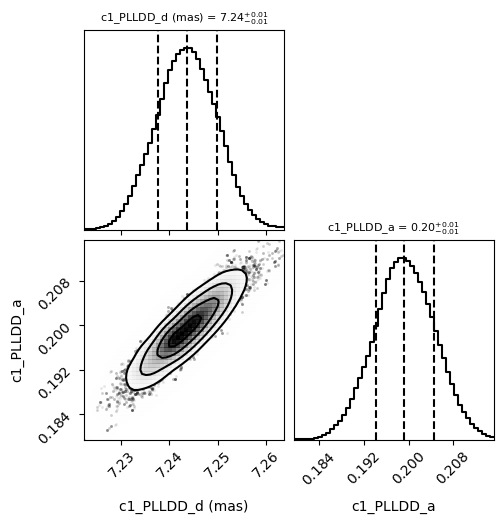

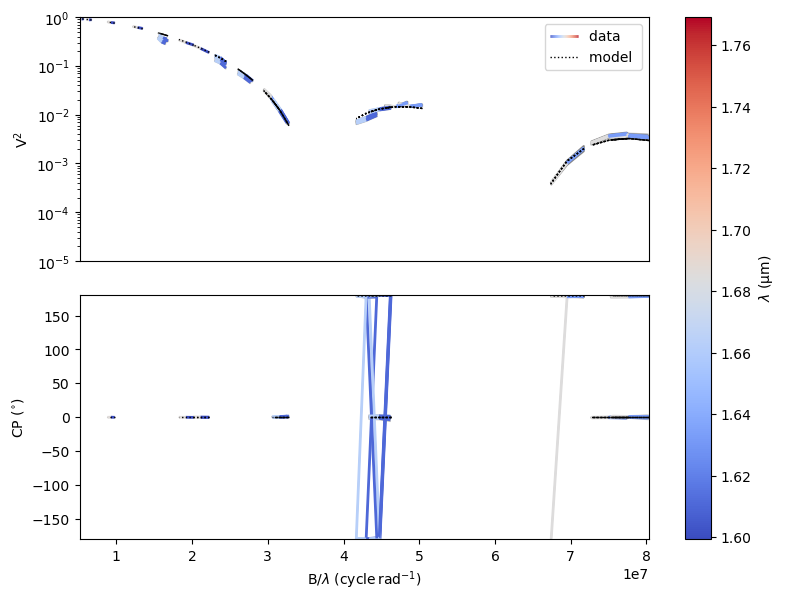

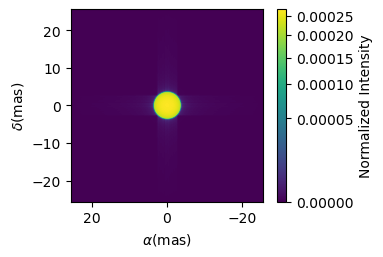

In [17]:
fit = oim.oimFitterEmcee(files,model_pldd,nwalkers=20,
                         dataTypes=["VIS2DATA","T3PHI"])
fit.prepare(init="random")
fit.run(nsteps=2000, progress=True)

fit.walkersPlot()
fit.cornerPlot(discard=1000, chi2limfact=5)
fig, ax = fit.simulator.plot(["VIS2DATA","T3PHI"])
ax[0].set_yscale("log")
ax[0].set_ylim(1e-5,1)
fit.printResults(discard=1000, chi2limfact=5)
median,err_l,err_u,err = fit.getResults(discard=1000, chi2limfact=5)
figim, axim, im = model_pldd.showModel(512,0.1,fromFT=True)

#### **Question: Is the limb-Darkening significantly constrained?**

#### Using the **oimFitterRegularGrid** object we can create a 2D $\chi^2_r$ map with the diameter and limb-darkening coefficient as free parameters.

In [18]:
grid=oim.oimFitterRegularGrid(files,model_pldd,dataTypes=["VIS2DATA","T3PHI"])
grid.prepare(steps=[0.02,0.02],min=[5,0],max=[9,1])
grid.run()

100%|███████████████████████████████████████████████████████████████████████████| 10251/10251 [00:11<00:00, 857.71it/s]


{}

To enhance the image dynamic we can set the maximum value of the $\chi^2_r$ to 100 and/or overplot a contour showing twice the minimum of $\chi^2_r$.

2


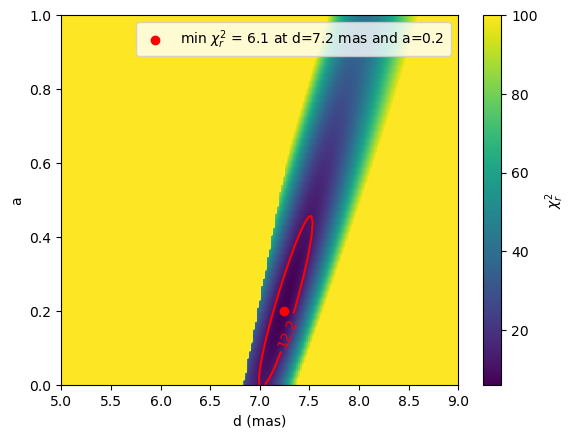

In [19]:
fig,ax = grid.plotMap(aspect="auto",plotContour=True,vmax=100)

#### **Question: are the diameter and LDD coefficient correlated?**

### Let's see what would happen to our $\chi^2_r$ map if we would only have short baselines.

To modify our dataset we will use **oimodeler** data-filtering capability. To do so we will:
- load our data into a oimData object (this was done automatically in the previous examples)
- create an  expression-based filter, removing all baselines longer than 50 meters
- apply this filter to our oimData object


In [20]:
filt=oim.oimFlagWithExpressionFilter(expr="LENGTH>50")
data=oim.oimData(files)
data.setFilter(filt)

### Now we can create and plot a new grid explorer using this filtered dataset.

In [21]:
grid2=oim.oimFitterRegularGrid(data,model_pldd,dataTypes=["VIS2DATA","T3PHI"])
grid2.prepare(steps=[0.02,0.02],min=[5,0],max=[9,1])
grid2.run()

100%|███████████████████████████████████████████████████████████████████████████| 10251/10251 [00:11<00:00, 903.29it/s]


{}

2


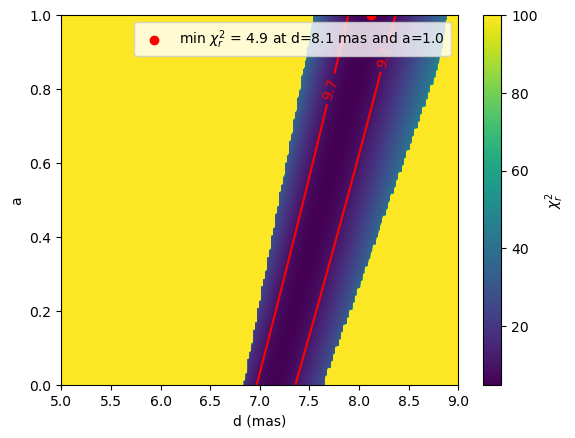

In [22]:
fig,ax=grid2.plotMap(vmax=100,plotContour=True)

#### **Question: What is the $\chi^2_r$ map showing?**

#### **Question: Conclude on what is needed to constrain limb-darkening**

**Tip:** Use the formula of the first zero of visibility for a Uniform disk